# Задача

В рамках вступительного экзамена предлагается самостоятельно обучить модель OCR для автомобильных номеров.

OCR = Optical Character Recognition


#### Пример входа:

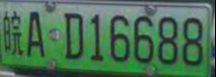

#### Пример выхода: ” 皖AD16688”

# Предлагаемая архитектура решения



Блок 1 -- Fully-convolutional CNN (FCNN)  
Блок 2 -- Bi-LSTM  
Выход  -- Cross-entropy или [CTC-loss](https://www.cs.toronto.edu/~graves/icml_2006.pdf)

Можно использовть любую другую подходящую для данной задачи архитектуру.

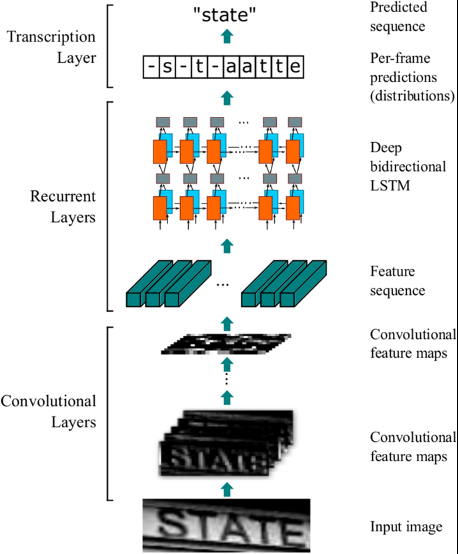

# Данные

Предлагается использовать корпус [CCPD2019](https://github.com/detectRecog/CCPD). Специально для участников отбора были выделены регионы интереса и метки из исходного корпуса. В test вошли изображения из CCPD-weather. Подготовленный корпус можно скачать по [ссылке](https://disk.yandex.ru/d/adjYzzNayB1pag).

# Решение

Перед началом решения данной задачи я захотел посмотреть, откуда взята картинка со схемой модели, чтобы немного поглубже вникнуть в задачу и выяснить, на какие идеи не стоит терять время, а что можно попробовать в качестве бейзлайна.


Поиск почти сразу вывел меня на [оригинальную статью](https://arxiv.org/pdf/1507.05717v1.pdf), где авторы предложили архитектуру RCNN, объяснив ее преимущества перед прошлыми. Одно из упомянутых преимуществ такой архитектуры -- независимость работы модели от длины входа: предлагалось лишь отмасштабировать картинку по высоте на 32 пикселя, при этом на ее ширину никаких ограничений не налагалось.

Заметив (в "черновике" был написан соответствующий небольшой код, похожий на выделение метки изображения в методе $\text{__getitem__}$ класса PicturesDataset, но с добавлением проверки на равенство длины метки 7 символам), что каждая метка имеет фиксированную длину, я понял, что это поможет упростить решение задачи: я решил зафиксировать размер изображения не только по высоте, но и по ширине, причем так, чтобы в конце CNN части в ширину изображение было ровно 7 пикселей (одна колонка на один символ в номере).

Исходя из размеров фильтров в опробованной мной архитектуре, вычислив размеры изображений в обратном порядке (от конца CNN части сети), я получил, что изображение на входе в ширину должно быть 112 пикселей. А размер в высоту я оставил 32 пикселя, как и у авторов оригинальной статьи.

In [172]:
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torchsummary

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [173]:
torch.cuda.is_available()

False

## Подготовка данных.

Нужно реализовать класс данных (наследник torch.utils.data.Dataset). Класс должен считывать входные изображения и выделять метки из имён файлов. Для чтения изображений предлагается использовать библиотеку OpenCV (методы cv2.imread, cv2.resize и cv2.cvtColor). В базовом варианте достаточно загрузить тренировочную и тестовую части корпуса. Можно также отделить валидационный корпус от тренировочного. Также предлагается реализовать механизм аугментаций для повышения качества обучения.

In [ ]:
from skimage import io, img_as_float
from skimage import color
from skimage.transform import resize

In [3]:
class PicturesDataset(torch.utils.data.Dataset):
    def __init__(self, dir='./CCPD2019-dl1/train/'):
        super(self.__class__, self).__init__()
        self.dir = dir
        self.pictures_names = os.listdir(path=dir)
        self.len = len(self.pictures_names)
    
    def __len__(self):
        return self.len

    def __getitem__(self, index):
        name = self.pictures_names[index]
        
        # colors may be not useful, but harmful --> make picture gray
        image = color.rgb2gray(io.imread(self.dir + name))
        
        # labels have fixed size, 7 characters, resize the image to have 
        # 7 pixels at horizontal axes after CNN part of NN
        image = resize(image, (32, 112), anti_aliasing=True)
        
        # for feeding image to model we need 3D tensor
        image = torch.FloatTensor(image[None, :, :])
        
        # get true label since they are modified
        label = name[name.find('-') + 1 : name.find('.')]
        return image, label

In [4]:
train_dataset = PicturesDataset('./CCPD2019-dl1/train/')
test_dataset = PicturesDataset('./CCPD2019-dl1/test/')

In [5]:
len(train_dataset), len(test_dataset)

(199980, 9999)

Посмотрев на несколько примеров изображений номеров и их метки, я понял, что иероглифы могут быть только на первом месте (на позиции 0), а дальше могут и цифры и латинские буквы. Поэтому я решил понять, какие символы вообще могут стоять на каждой позиции. При построении модели я буду предсказывать на каждой позиции символ из соответствующего множества.

In [7]:
# positions = [set()] * 7             # -- wrong way, it uses the same set() further
positions = [set() for _ in range(7)] # correct way: it uses seperate sets

for idx in tqdm(range(len(train_dataset))):
    label = train_dataset.__getitem__(idx)[1]
    for pos in range(7):
        positions[pos].add(label[pos])

100%|██████████| 199980/199980 [09:53<00:00, 336.90it/s]


In [14]:
# positions

In [17]:
import pickle

# here it is important to use 'b' flag for files
with open('positions.pkl', 'ab+') as f:
    pickle.dump(positions, f)

True

In [213]:
with open('positions.pkl', 'rb') as f:
    positions = pickle.load(f)
positions_copy == positions

True

In [20]:
for pos in range(7):
    print(
        f'position: {pos}\n' + \
        f'possible characters: {positions[pos]}\n'
    )

position: 0
possible characters: {'辽', '川', '甘', '黑', '鲁', '吉', '闽', '宁', '沪', '贵', '青', '皖', '桂', '冀', '豫', '蒙', '粤', '新', '晋', '苏', '浙', '赣', '藏', '津', '渝', '陕', '京', '云', '湘', '琼', '鄂'}

position: 1
possible characters: {'B', 'J', 'E', 'Q', 'M', 'H', 'D', 'S', 'V', 'G', 'N', 'X', 'L', 'C', 'U', 'F', 'K', 'R', 'P', 'W', 'Z', 'Y', 'A', 'T'}

position: 2
possible characters: {'B', '0', 'J', '4', 'E', 'Q', '2', 'M', 'H', 'D', 'S', '6', '5', 'V', 'G', 'N', 'X', 'L', 'C', 'U', '3', 'F', 'K', 'R', '8', 'P', 'W', '1', '9', '7', 'Z', 'Y', 'A', 'T'}

position: 3
possible characters: {'B', '0', 'J', '4', 'E', 'Q', '2', 'M', 'H', 'D', 'S', '6', '5', 'V', 'G', 'X', 'N', 'L', '3', 'C', 'U', 'F', 'K', 'R', '8', 'P', 'W', '1', '9', '7', 'Z', 'Y', 'O', 'A', 'T'}

position: 4
possible characters: {'B', '0', 'J', '4', 'E', 'Q', '2', 'M', 'H', 'D', 'S', '6', '5', 'V', 'N', 'X', 'G', 'L', '3', 'C', 'U', 'F', 'K', 'R', '8', 'P', 'W', '1', '9', '7', 'Z', 'Y', 'A', 'T'}

position: 5
possible characters: {'

Внимательно посмотрев на позиции 0 и 1, можно понять, что на на 0 позиции действительно могут быть только иероглифы, а на позиции 1 могут быть только латинские буквы, но не цифры. При этом на последующих позициях могут быть и цифры, и латинские буквы. Видно так же, что на позиции 3 может находиться на 1 символ больше, чем на позициях 2, 4, 5, 6, множества символов которых совпадают. Проверим это.

In [215]:
positions[2] == positions[4], \
positions[4] == positions[5], \
positions[5] == positions[6], \
positions[3] - positions[2], \
positions[2] - positions[3]

(True, True, True, {'O'}, set())

Действительно, позиция 3 отличается от позиций 2, 4, 5, 6 лишь символом 'O'. При этом на позициях 2, 4, 5, 6 могут быть одни и те же символы. получены множества возможных меток для всех позиций в номере автомобиля.

Для простоты можно считать, что на позиции 2-6 можно поставить одни и те же символы.  
Тогда можно задать лишь три множества символов -- для позиций 0, 1 и 2.

In [22]:
pos_0_idx_to_chars = sorted(list(positions[0]))
pos_1_idx_to_chars = sorted(list(positions[1]))
pos_2_idx_to_chars = sorted(list(positions[3])) # for postitions 2-6

pos_0_chars_to_idx = {char: idx for idx, char in enumerate(pos_0_idx_to_chars)}
pos_1_chars_to_idx = {char: idx for idx, char in enumerate(pos_1_idx_to_chars)}
pos_2_chars_to_idx = {char: idx for idx, char in enumerate(pos_2_idx_to_chars)}

Теперь осталось лишь создать два dataloader'а: для тренировочной и тестовой выборки данных. Я решил не делить тренировочную выборку для получения валидационной выборки, так как сначала я хотел получить некоторый бейзлайн как можно быстрее, а затем я смог подобрать параметры и архитектуру, дающую accuracy предсказания меток целиком порядка 95-96% и accuracy предсказания символов порядка 97-99%.

In [113]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

## Создание и обучение модели.

Код модели должен быть реализован через слои стандартной библиотеки torch (torchvision.models и аналоги использовать нельзя). Поскольку число символов в номерах фиксировано, можно использовать обычный кросс-энтропийный критерий. Желающие могут использовать и CTC-loss. Цикл обучения можно реализовать самостоятельно или воспользоваться библиотеками PyTorch Lightning / Catalyst.

### Детали архитектуры модели

Поскольку размер изображений был выбран (32, 112), что довольно немного, есть возможность сделать модель немного побольше, и при этом суметь обучить ее меньше, чем за положенный час. 

Первая (CNN) часть модели выглядит так:  
1. Conv2d, MaxPool2d, ReLU  
2. Conv2d, MaxPool2d, ReLU  
3. BatchNorm2d, Dropout2d
4. Conv2d, MaxPool2d, ReLU  
5. BatchNorm2d, Dropout2d
6. Conv2d, MaxPool2d

Далее, для использования BiLSTM, нужно получить последовательности. Я решил конкатенировать соответствующие колонки по всем feature maps на выходе CNN части сети (эту же мысль увидел в статье о CRNN). Батч имеет размер (N, C, H, W), нужно сконкатенировать выход CNN по 1 (C) и 2 (H) оси. Ширина feature map на выходе CNN -- 7 пикселей, поэтому теперь батч имеет размер (N, C * H, 7). Но для подачи в BiLSTM нужно, чтобы каждому объекту соответствовало 7 векторов (то есть 7 должно стоять на оси 1, а не 2), значит надо транспонировать тензор по 1 и 2 осям. Итоговый размер батча перед рекуррентной частью ести -- (N, 7, C * H). 

Дальше логика была такая: в номере 7 символов, размер символов примерно одинаковый в ширину, поэтому можно получить 7 векторов состояний из RNN, по которым дальше отдельно предсказывать символ на соответствующую позицию, обучив несколько независимых классификаторов для каждой позиции. Для этого ранее были найдены множества возможных символов на каждую позицию. Классификаторы символов для каждой позиции одинаковые (за исключением числа нейронов на выходном слое):
1. Linear, BatchNorm1d, ReLU
2. Linear, BatchNorm1d, ReLU
3. Linear

In [262]:
class MyModel(nn.Module):
    def __init__(
        self, lstm_bidir=True, lstm_hid=48, lstm_dropout=0.0, 
        lstm_num_layers=1, backbone_dropout=0.0
    ):
        super(MyModel, self).__init__()
        
        self.backbone_dropout = backbone_dropout
        
        self.backbone = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=50, kernel_size=3, stride=1, padding=1), # (32, 112) --> (32, 112)
            nn.MaxPool2d(kernel_size=2, stride=(2, 2)), # (32, 112) --> (16, 56)
            nn.ReLU(),
            nn.Conv2d(in_channels=50, out_channels=100, kernel_size=3, stride=1, padding=1), # (16, 56) --> (16, 56)
            nn.MaxPool2d(kernel_size=2, stride=(2, 2)), # (16, 56) --> (8, 28)
            nn.ReLU(),
            nn.BatchNorm2d(num_features=100),
            nn.Dropout2d(p=self.backbone_dropout),
            nn.Conv2d(in_channels=100, out_channels=160, kernel_size=3, stride=1, padding=1), # (8, 28) --> (8, 28)
            nn.MaxPool2d(kernel_size=2, stride=(2, 2)), # (8, 28) --> (4, 14)
            nn.ReLU(),
            nn.BatchNorm2d(num_features=160),
            nn.Dropout2d(p=self.backbone_dropout),
            nn.Conv2d(in_channels=160, out_channels=280, kernel_size=3, stride=1, padding=1), # (4, 14) --> (4, 14)
            nn.MaxPool2d(kernel_size=2, stride=(2, 2)), # (4, 14) --> (2, 7), 280 feature maps
        )
        
        # (N, C, H, W) size of batch with N objects with C feature maps
        # (?, 280, 2, 7) --> (?, 560, 7) to get info from all feature
        self.flatten = nn.Flatten(start_dim=1, end_dim=2)
        
        self.lstm_bidir = lstm_bidir
        self.lstm_hid = lstm_hid
        self.lstm_dropout = lstm_dropout
        self.lstm_num_layers = lstm_num_layers
        
        self.bilstm = nn.LSTM(
            input_size=560, hidden_size=lstm_hid,
            num_layers=lstm_num_layers, dropout=lstm_dropout, 
            bidirectional=lstm_bidir, batch_first=True
        )
        
        lstm_output_size_factor = 2 if lstm_bidir else 1
        lstm_output_size = lstm_output_size_factor * self.lstm_hid

        self.all_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(in_features=lstm_output_size, out_features=128),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Linear(in_features=128, out_features=64),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Linear(
                    in_features=64, 
                    out_features=(
                        len(pos_0_idx_to_chars) if pos == 0 else 
                        len(pos_1_idx_to_chars) if pos == 1 else
                        len(pos_2_idx_to_chars)
                    )
                ), 
                # nn.ReLU() 
                # , nn.Softmax() # bad for CrossEntropyLoss, which needs logits
            )
            for pos in range(7)
        ])
    
    def forward(self, pic):
        vec = self.backbone(pic)
        
        # concatenate feature map columns ---> feature sequences for RNN
        vec = self.flatten(vec)
        
        # axes we have: (batch_size objects, values, cols)
        # axes we need: (batch_size objects, cols, values)
        vec = torch.transpose(vec, 1, 2)
        
        # get per-frame logits (position ---> characters logits)
        vec, _ = self.bilstm(vec)
        
        # compute logits for every character for every position
        # batch: (N, 7, C * H) --> for i-tj position use vec[:, i, :]
        logits_position_batch = [
            head(vec[:, i, :]) for i, head in enumerate(self.all_heads)
        ]
        return logits_position_batch

In [217]:
def get_one_hot_pos(pos, labels):
    """ 
    returns one hot vector for characters at some position for every car number
    pos -- position at car numbers
    labels -- characters at position in car numbers
    """
    if pos == 0:
        res = torch.eye(len(pos_0_chars_to_idx))
        idxs = [pos_0_chars_to_idx[l] for l in labels]
    elif pos == 1:
        res = torch.eye(len(pos_1_chars_to_idx))
        idxs = [pos_1_chars_to_idx[l] for l in labels]
    else:
        res = torch.eye(len(pos_2_idx_to_chars))
        idxs = [pos_2_chars_to_idx[l] for l in labels]
    return res[idxs]

def get_one_hot(batch_labels):
    """ 
    returns one hot matrix for every column (position=0,1,...,6) in batch_labels
    batch_labels -- strings with 7 characters for every picture in batch
    """
    batch_labels = np.array(list(map(list, batch_labels)))
    # print(batch_labels)
    batch_pos_labels = [
        get_one_hot_pos(pos, batch_labels[:, pos])
        for pos in range(7)
    ]
    return batch_pos_labels

In [253]:
import time

def get_duration(start, finish):
    finish = time.time()
    delta = int(finish - start)
    h, m, s = delta // 3600, delta % 3600 // 60, delta % 60
    return f'{h}h {m}m {s}s'

def train(model, dataloader, loss_func, opt, epochs=5, lr_sched=None):
    start = time.time()
    train_loss = []
    
    for e in range(epochs):
        train_loss_epoch = []
        for i, (x_batch, y_batch) in enumerate(dataloader):
            batch_pos_labels = get_one_hot(y_batch) # every label --> list of 7 one hot vectors
            
            # batch_size lists of 7 lists with logits for 7 poistions
            batch_logits_per_position = model(x_batch)
            
            loss = 0.0
            for y_pos_logits, y_pos_true in zip(batch_logits_per_position, batch_pos_labels):
                loss += loss_func(y_pos_logits, y_pos_true)
            
            loss.backward()
            opt.step()
            opt.zero_grad()
            if lr_sched is not None and lr_sched.get_lr()[0] > 1e-3: 
                # min lr will be a bit < 1e-3
                # (1e-3 + eps) * lr_sched.gamma may be < 1e-3 
                lr_sched.step()
            
            train_loss_epoch.append(loss.item())
            if (i + 1) % 5 == 0:
                clear_output(wait=True)
                plt.figure(figsize=(8, 8))
                plt.title(
                    f'Epoch {e}, batch {i + 1} / {len(dataloader)}\n' + \
                    f'training time: {get_duration(start, time.time())}\n'+ \
                    f'loss: {loss.item():.2e}, lr: {lr_sched.get_lr()[0]:.2e}'
                )
                plt.plot(range(1, 2 + i), train_loss_epoch, label='loss')
                plt.yscale('log')
                plt.legend()
                plt.show();
        
        # train_loss.append(np.mean(train_loss_epoch))
    # return train_loss

Сначала я попробовал модель с не очень большой размерностью скрытого слоя LSTM (96 и 128), но лучший результат удался при lstm_hid = 160. Также немного лучше стало от добавления небольшого дропаута в качестве регуляризатора. Не последнюю роль, по моему мнению, сыграло использование lr_scheduler и установление подходящего начального learning_rate = 2e-3. И так как объектов в выборке очень много, а по графику было видно падение ошибки до 0.1 уже после 500 с небольшим батчей (1 батч = 64 картинки) с незначительными изменениями далее, я решил обучать модель в течение только одной эпохи.

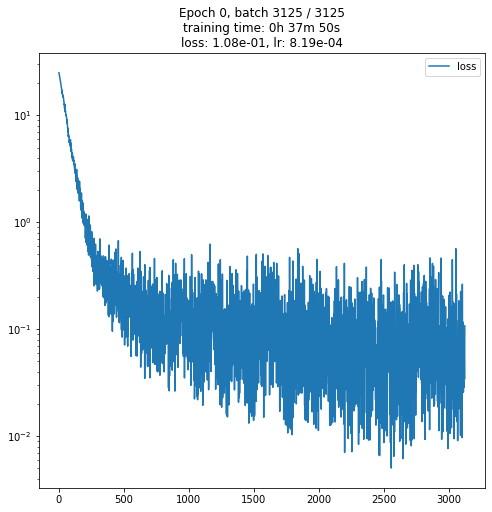

In [259]:
model = MyModel(
    lstm_bidir=True, lstm_num_layers=1,
    lstm_hid=160, lstm_dropout=0.05, backbone_dropout=0.05
)
opt = torch.optim.Adam(model.parameters(), lr=2e-3)
lr_sched = torch.optim.lr_scheduler.StepLR(opt, step_size=200, gamma=0.8)
loss_func = torch.nn.functional.cross_entropy # CrossEntropyLoss()

train(model, train_dataloader, loss_func, opt, epochs=1, lr_sched=lr_sched)

График может показаться шумным, но стоит заметить, что ось ординат, соответствующая лоссу, имеет логарифмическое масштабирование, поэтому, на самом деле, лосс не такой шумный.

In [260]:
# save current best model
PATH = 'model_bidir_1_160_005_005_.pt'
torch.save(model.state_dict(), PATH)

# check correctness
the_model = MyModel(
    lstm_bidir=True, lstm_num_layers=1,
    lstm_hid=160, lstm_dropout=0.05, backbone_dropout=0.05
)
the_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Подсчет метрик.

Качество модели должно оцениваться по двум метрикам: accuracy и Character Error Rate (CER). Accuracy считает долю правильно распознанных номеров. CER оценивает число посимвольных ошибок. Можно реализовать метрики самостоятельно или взять готовые реализации из интернета.

Обычно под метрикой понимается некоторая величина, для которой лучше быть больше нежели меньше. Поэтому я вычислил не долю посимвольных ошибок, а, наоборот, долю правильных посимвольных предсказаний модели.

In [263]:
def pred_to_string(pred):
    label = pos_0_idx_to_chars[pred[0]] + \
            pos_1_idx_to_chars[pred[1]] + \
            "".join([pos_2_idx_to_chars[pred[i]] for i in range(2, 7)])
    return label

def batch_logits_to_preds(batch_logits_per_position):
    batch_preds_per_position = [
        nn.Softmax(dim=1)(x).argmax(dim=1) for x in batch_logits_per_position
    ]
    batch_preds = torch.stack(batch_preds_per_position, dim=1)
    preds = [
        pred_to_string(pred)
        for pred in batch_preds
    ]
    return preds

def compare_chars(preds, y_batch):
    same_chars, same_words = 0, 0
    for a, b in zip(preds, y_batch):
        same_words += (a == b)
        for i in range(7):
            if a[i] == b[i]:
                same_chars += 1
    return same_chars, same_words

def eval_model(model, dataloader, check_objects_cnt, accuracy_char=True):
    """ compute characters and labels accuracies """
    cur_cnt_objects = 0
    
    chars_accuracy, labels_accuracy = 0, 0
    for x_batch, y_batch in dataloader:
        batch_logits_per_position = model(x_batch)
        preds = batch_logits_to_preds(batch_logits_per_position)
        
        same_chars, same_words = compare_chars(preds, y_batch)
        chars_accuracy += same_chars
        labels_accuracy += same_words

        cur_cnt_objects += len(x_batch)
        if cur_cnt_objects >= check_objects_cnt:
            break
    chars_accuracy = chars_accuracy / (cur_cnt_objects * 7)
    labels_accuracy = labels_accuracy / cur_cnt_objects
    return chars_accuracy, labels_accuracy

In [261]:
model.eval()

start = time.time()
chars, words = eval_model(model, test_dataloader, check_objects_cnt=len(test_dataset))
finish = time.time()
print(f'Test accuracy: {words * 100:.2f}% labels, {chars * 100:.2f}% chars')
print(f'Test eval time: {get_time(start, finish)} total, {(finish - start) / len(test_dataset):.5f} per object')

start = time.time()
chars, words = eval_model(model, train_dataloader, check_objects_cnt=len(train_dataset))
finish = time.time()
print(f'Train accuracy: {words * 100:.2f}% labels, {chars * 100:.2f}% chars')
print(f'Train eval time: {get_time(start, finish)} total, {(finish - start) / len(train_dataset):.5f} per object')

Test accuracy: 95.68% words, 99.24% chars
Test eval time: 0h 0m 56s total, 0.00565 per object
Train accuracy: 98.67% words, 99.80% chars
Train eval time: 0h 19m 4s total, 0.00572 per object


Видно, что label accuracy на тесте выше 95%, что очень неплохо. Посимвольные предсказания так вообще имеют точность выше 99%. При этом стоит отметить высокую скорость работы модели на одном изображении -- чуть больше 5.5 миллисекунд (включая и последующую проверку правильности предсказания).

## Анализ ошибок модели.

В этой секции нужно найти изображения из тестового корпуса, на которых модель ошибается сильнее всего (по loss или по CER). Предлагается выписать в ноутбук возможные причины появления этих ошибок и пути устранения.

Чтобы проанализировать ошибки, нужно посмотреть на несколько худших предсказаний и на картинки с истинными метками, для которых они были даны. Рассмотрим 40 худших предсказаний по значению лосса (с наибольшим его значением).

In [225]:
worst_cnt = 40

In [226]:
# for iterating by single picture
test_dataloader_2 = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [228]:
worst_pictures = [] # (loss, picture)
min_loss = -1

m = model
m.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_dataloader_2, desc='Total'):
        batch_pos_labels = get_one_hot(y_batch) # every label --> list of 7 one hot vectors
        batch_logits_per_position = m(x_batch)
        preds = batch_logits_to_preds(batch_logits_per_position)
        
        loss = 0.0
        for y_pos_logits, y_pos_true in zip(batch_logits_per_position, batch_pos_labels):
            loss += loss_func(y_pos_logits, y_pos_true)
        
        if loss.item() > min_loss:
            worst_pictures.append((loss.item(), x_batch[0], y_batch[0], preds[0]))
            worst_pictures = sorted(worst_pictures)
            min_loss = worst_pictures[0][0]

        if len(worst_pictures) > worst_cnt:
            worst_pictures = worst_pictures[1:]

Total: 100%|██████████| 9999/9999 [01:48<00:00, 92.02it/s] 


In [229]:
worst_losses = [np.round(x[0], decimals=2) for x in worst_pictures]
print(f'The biggest {worst_cnt} losses: min is {np.min(worst_losses)}, max is {np.max(worst_losses)}')

The biggest 40 losses: min is 8.97, max is 28.71


In [243]:
print('Errors in labels for these objects (best on the top/left side):\n')
print(('Correct -- Prediction' + ' ' * 5) * 4 + '\n')

col_height = len(worst_pictures) // 4
for i in range(col_height):
    for j in range(4):
        x = worst_pictures[col_height * j + i]
        print(x[2], ' ' * 3, x[3], ' ' * (4 + (j > 0)), end='')
    print()

Errors in labels for these objects (best on the top/left side):

Correct -- Prediction     Correct -- Prediction     Correct -- Prediction     Correct -- Prediction     

浙A368SP     皖A368SP     皖AM2C76     皖AM2Q76      皖A96A39     皖AVGA59      皖A82740     皖AG2V80      
皖AY613U     皖AX613U     琼BL1507     粤BL1507      皖A1666M     皖AL666M      皖A619V9     皖A618KR      
皖AT1072     皖AT10Z2     皖A9L190     皖A9L180      皖A952U2     皖A952D2      皖AG2Z62     皖A02W8R      
皖A751S6     皖A75156     皖AK626R     鄂AK6265      皖ANY833     皖ANY645      皖AD0T89     苏LDDT02      
吉BTW976     皖BTW9Z6     皖ABS001     皖ABS007      皖AZW063     皖A2KD63      皖AA6W68     皖A14W48      
皖AH776S     皖AH7768     皖AGH926     皖A06926      皖AF888S     皖AFWQ99      皖A2W003     皖A3W555      
皖AQX712     皖AQXZL2     皖N1G886     皖NT0886      皖AB1930     沪AB1Q30      皖APY862     皖AP3020      
皖AYU642     皖AY16J2     皖AAU712     闽KAUV12      皖ASW824     皖ASW886      皖ABJ356     浙AB356J      
皖A193S5     皖A19355     皖A1E2

Здесь выше выведены 40 худших (по значению лосса) предсказаний модели на тестовой выборке. Слева сверху выписаны более удачные, снизу справа менее правильные. Видно что весь первый столбик имеет довольно похожие предсказанные и истинные метки. Это же верно и для второго и третьего столбиков, хотя внизу третьего уже больше ошибок (3 посимвольные ошибки в нижней метке третьего столбика). А вот внизу в четвертом столбике заметны уже совсем большие различия. Посмотрим на сами изображения. Слева и сверху изображения с наименьшим лоссом, снизу и справа -- с наибольшим.

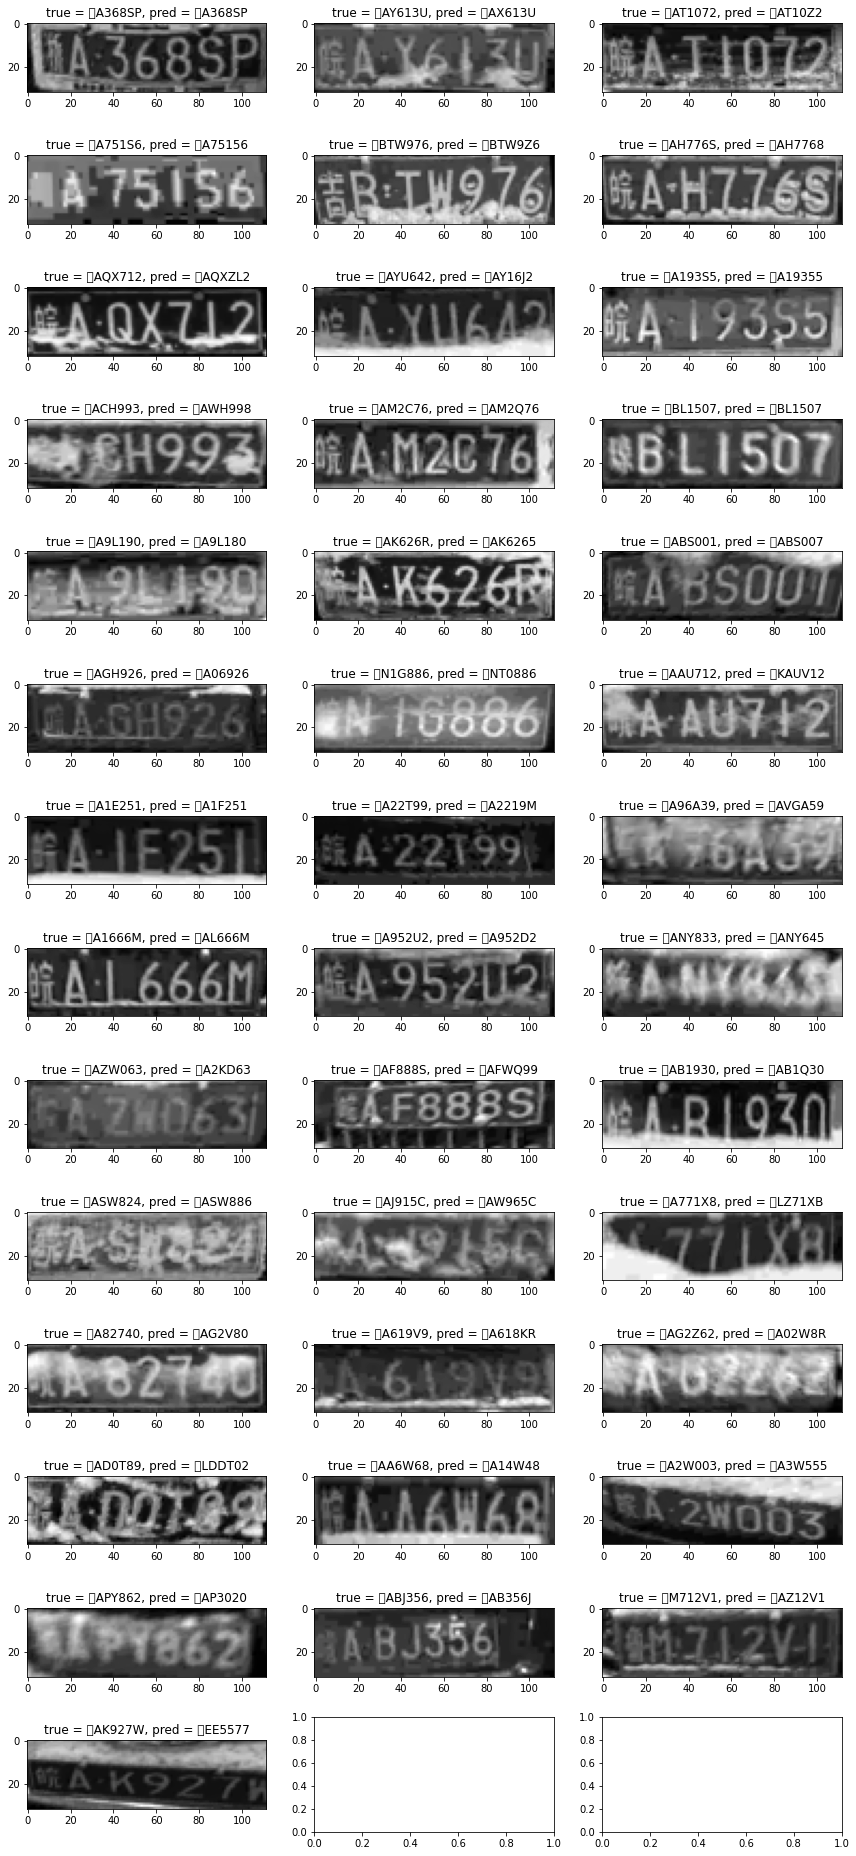

In [247]:
from warnings import filterwarnings
filterwarnings(action='ignore')

fig, axes = plt.subplots(worst_cnt // 3 + 1, 3, figsize=(12, worst_cnt // 3 * 2))

for i in range(worst_cnt):
    plt.subplot(worst_cnt // 3 + 1, 3, i+1)
    plt.title(f'true = {worst_pictures[i][2]}, pred = {worst_pictures[i][3]}')
    plt.imshow(worst_pictures[i][1][0], cmap='gray')

plt.tight_layout()
plt.show();

Среди этих 40 изображений последние 10 как раз были в 4 столбике. 

Видно, что на большинстве из них и правда сложно разглядеть надпись сразу, на некоторых качество фотографии совсем плохое. Однако, есть и довольно четкие фотографии, на которых можно неправильно угадать лишь 1 символ (например, самая последняя картинка, или же третья с конца).

Если вспомнить, что на выходе из CNN части я сделал feature maps ровно 7 пикселей в ширину, исходя из предположения, что символы на картинке располагаются равномерно (заполняют всю ширину картинки), что и позволило бы классифицировать отдельно символы на каждой из 7 позиций, то понятна причина ошибки предсказания на третьей с конца картинке --- там символы сдвинуты налево, и, скорее всего, последняя часть была принята за отдельный символ, при том, что его там нет. Подобную проблем можно было бы решить большим "дроблением" -- использовать последовательность для RNN не из 7 векторов, а, например, из 14. Но тогда возникает проблема детекции двух одинаковых символов подряд (пример -- шестая картинка с конца).

В итоге, вариантов улучшения есть 2:
1. пытаться улучшить качество предобработки данных (убирать шумы, "дорисовывать" легко заполняемые недостающие кусочки картинок, убирать лишние куски без символов как на третьей с конца картинке)
2. улучшить алгоритм так, чтобы он имел более широкие feature maps на выходе из CNN и мог обрабатывать одинаковые символы, заполняя постепенно некоторый буфер с предсказанием и останавливаясь после заполнения его 7 символами)